# Wilks' Theorem

In lectures, we saw how Wilks' theorem can be used to obtain intervals when using a profiled likelihood ratio as our test statistic. 

Suppose we have an analysis in which the number of events in bins of a distribution is counted. There is a background process and two signal processes with signal strength modifiers $\mu_1$ and $\mu_2$, with no restrictions on their range. Our log-likelihood function for this will be, 

$$
    q(\mu_1,\mu_2) = -2 \left(\sum_{i} n\ln{\lambda_{i}}- \lambda_{i} \right)
$$

where $i$ runs over the bins, $\lambda_{i}=\mu_{1}s_{i,1}+\mu_{2}s_{i,2}+b_{i}$.


The background, signal and data distributions are shown below

The model is defined by specifying the bin contents, and the nominal value of our nuisance parameter as follows.

In [1]:
import numpy
import sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

signal1_counts    = numpy.array([0,0,0,0.5,1,2,3,4,5,4.5,4.0,3.5,3.0,2.5,2,1.5,1,0.5,0,0,0,0,0,0,0])
signal2_counts    = numpy.array([0,0,1,2,3,4,5,6,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
background_counts = numpy.array([60*numpy.exp(-0.1*i) for i in range(len(signal1_counts))])

nbins = len(signal1_counts)

data = numpy.array([65, 45, 47, 37, 37, 40, 42, 36, 34, 36, 22, 23, 23, 18, 17, 13, 12, 12, 11, 12, 6, 6, 6, 9, 4])

nbins = len(data)

def signal1(mu1):
  return mu1*signal1_counts

def signal2(mu2):
  return mu2*signal2_counts  

def expectations(mu1,mu2):
  return mu1*signal1_counts+mu2*signal2_counts+background_counts


Let's make a plot of the data and expectation from the background and signals. This will depend on the values of our two parameters $\mu_{1}$ and $\mu_{2}$

In [2]:
import ipywidgets

xrange = numpy.linspace(0,nbins,nbins)
edges  = numpy.linspace(-0.5,nbins+0.5,nbins+1)

def plot_likelihood(mu1,mu2):
  plt.plot(xrange,data,marker='o',linestyle='none',color='black',label='Data')
  
  plt.stairs(expectations(mu1,mu2),edges,color='red',label='$B+\mu_{1}S_{1}+\mu_{2}S_{2}$')
  plt.stairs(background_counts+signal1(mu1),edges,color='blue',label='$B+\mu_{1}S_{1}$')
  plt.stairs(background_counts+signal2(mu2),edges,color='green',label='$B+\mu_{2}S_{2}$')
  plt.stairs(background_counts,edges,linestyle='--',color='black',label='B')
  plt.xlabel("Bin")
  plt.ylabel("Events")
  plt.legend()

ipywidgets.interact(plot_likelihood,mu1=(0,3,0.2),mu2=(0,3,0.2))

interactive(children=(FloatSlider(value=1.0, description='mu1', max=3.0, step=0.2), FloatSlider(value=1.0, des…

<function __main__.plot_likelihood(mu1, mu2)>

Of course, we want to use the likelihood to find the best values of the parameters $\mu_{1}$ and $\mu_{2}$.

First we need to define our functions to evaluate $q$

In [3]:
# now define the log-Poisson means
@numpy.vectorize
def lamb(s1,s2,b):
  return s1+s2+b

@numpy.vectorize
def log_poisson(data_in,signal1,signal2,background,mu1,mu2):
  l = lamb(mu1*signal1,mu2*signal2,background)
  return data_in*numpy.log(l) - l

from scipy.optimize import minimize

def q(data,mu1,mu2):
  return  -2*sum(log_poisson(data,signal1_counts,signal2_counts,\
                        background_counts,mu1,mu2)) 

def q_unconstrained(x, args):
  mu1, mu2 = x[0], x[1]
  #data = args[0]
  return q(args,mu1,mu2)

def q_constrained(x, args):
  data, mu1, mu2 = args[0], args[1], args[2]
  return q(data,mu1,mu2)

def global_min(data):
  init_params = [0.1,0.1]
  bounds = [(-10,10),(-10,10)]
  mle = minimize(q_unconstrained,init_params,args=data,bounds=bounds)
  return mle.fun,mle.x[0],mle.x[1]

def delta_q(data,mu1,mu2,q_min):
  q_value        = q(data,mu1,mu2)
  return q_value-q_min

First, let's find the profiled value of our two  signal strengths (these are the values used in the figure above).

In [4]:
q_min,mu1_min,mu2_min   = global_min(data)
print("minimum of q = ",q_min," for mu_1=",mu1_min,"mu_2=",mu2_min)

minimum of q =  -2947.5225236257943  for mu_1= 1.0265476865535694 mu_2= 0.4116196568598055


Next, we scan the value of, 

$$
\Delta q(\mu_1,\mu_2) =  q(\mu_1,\mu_2) - q(\hat{\mu}_1,\hat{\mu}_2).
$$

in  a 2D grid

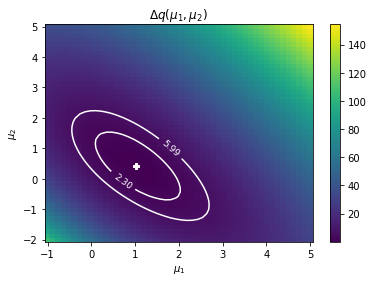

In [5]:
mu1_axis = numpy.linspace(-1,5,50)
mu2_axis = numpy.linspace(-2,5,50)
z = [ [delta_q(data,m1,m2,q_min) for m1 in mu1_axis] for m2 in mu2_axis]

X,Y = numpy.meshgrid(mu1_axis,mu2_axis)
c = plt.pcolor(X,Y,z)
plt.colorbar(c)
conts = plt.contour(X,Y,z,[2.3,5.99],colors="white")
plt.clabel(conts, fontsize=9, inline=1)
plt.xlabel("$\\mu_{1}$")
plt.ylabel("$\\mu_{2}$")
plt.title("$\Delta q(\mu_{1},\mu_{2})$")
plt.plot([mu1_min],[mu2_min],color="white",marker="P")
plt.savefig("likelihood_scan_mu1_mu2.pdf")
plt.show()

Using Wilks' theorem, the 68.3\% and 95.4\% confidence regions are the regions for which $ \Delta q(\mu_1,\mu_2) < 2.3$ and  $ \Delta q(\mu_1,\mu_2) < 5.99$ respectively, as indicated by the contours. If we are interested in only the first parameter, $\mu_1$, then we can use the function,  

$$
    \Delta q(\mu_1) =  q(\mu_1,\hat{\mu}{2}(\mu_{1})) - q(\hat{\mu}_1,\hat{\mu}_2).
$$

In [6]:
# this function constrains mu1 (scan mu1)
def q_constrained_mu1(x, args):
  mu2   = x[0]
  data, mu1 = args[0], args[1]
  return q(data,mu1,mu2)

def profiled(data, mu1):
  init_params = [1.0]
  bounds =  [(-4,10)]
  res = minimize(q_constrained_mu1,init_params,args=[data,mu1],bounds=bounds)
  return res.x

def delta_qmu1(data,mu1,q_min):
  profiled_nuisances = profiled(data,mu1)
  q_value        = q(data,mu1,profiled_nuisances[0])
  return q_value-q_min

def delta_qmu1_fix(data,mu1,mu2,q_min):
  q_value        = q(data,mu1,mu2)
  return q_value-q_min

The 68.3\% and 95.4\% intervals are found as the region for which  $\Delta q(\mu_1)<1$ and $\Delta q(\mu_1)<4$, respectively. We can find these intersections using some code similar to that below, 

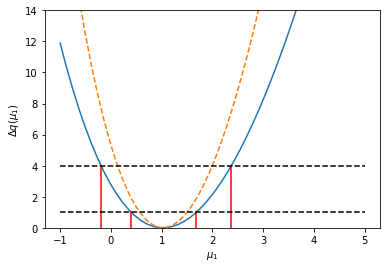

68.3% interval = (0.40,1.68)
95.4% interval = (-0.19,2.37)
Usually written as  mu_1=1.03, +0.66 -0.62


In [7]:
def return_crossing(x1,y1,x2,y2,K):
  m = (y2-y1)/(x2-x1)
  c = y1-m*x1
  return (K-c)/m,K

def findIntervals(x,y,conts=[1,4]):
  xx0,yy0 = x[0],y[0]
  crossing_x = []
  for xx,yy in zip(x[1:],y[1:]):
    for K in conts:
      if (yy < K and yy0 > K) or (yy > K and yy0 < K):
        crossing_x.append(return_crossing(xx0,yy0,xx,yy,K))
    xx0=xx
    yy0=yy
  return crossing_x

# plotting
mu1_axis = numpy.linspace(-1,5,50)
z = [ delta_qmu1(data,m1,q_min) for m1 in mu1_axis]
zf = [ delta_qmu1_fix(data,m1,mu2_min,q_min) for m1 in mu1_axis]
plt.plot(mu1_axis,z)
plt.plot(mu1_axis,zf,linestyle="--")
plt.xlabel("$\\mu_{1}$")
plt.ylabel("$\Delta q(\mu_{1})$")
intervals = findIntervals(mu1_axis,z,[1,4])
[ plt.plot([x[0],x[0]],[0,x[1]],color='red') for x in intervals ]
plt.ylim((0,14))
[ plt.plot([mu1_axis[0],mu1_axis[-1]],[k,k],color='black',linestyle='--') for k in [1,4] ]
plt.savefig("scan_mu1.pdf")
plt.show()

print("68.3%% interval = (%.2f,%.2f)"%(intervals[1][0],intervals[2][0]))
print("95.4%% interval = (%.2f,%.2f)"%(intervals[0][0],intervals[3][0]))

print("Usually written as  mu_1=%.2f, +%.2f -%.2f"%(mu1_min,intervals[2][0]-mu1_min,mu1_min-intervals[1][0]))


And we obtain the interval by finding the crossings at 1 and 4. 

If we didn't profile $\mu_{2}$, the intervals would be smaller, which shows the effect of correlations between parameters of interest. 

## Hessian approximation

Remember that in the lectures, we showed that expanding around the minimum of the likelihood yields a simple quadratic form. If we associate this with a Gaussian distribution for the parameters (or multi-normal distribution if there is more than one parameter of interest), then we can associate the variance with the second derivative of the negative log-likelihood.

In 1D, if we assume an approximate Gaussian distribution for $\mu$ we have that 

$$
\frac{1}{\sigma^{2}} = \frac{1}{2}q^{\prime\prime}(\hat{\mu}) = \frac{1}{2}\frac{d^{2}q}{d\mu^{2}}|_{\hat{\mu}}
$$

In our case, since we have 2-dimensions, we generalise to 

$$
(\nu_{1,1}^{\mu_{i},\mu_{j}})^{-1} = \frac{1}{2}
\begin{bmatrix}
\frac{\partial^2 q}{\partial \mu_{1}^{2}} & \frac{\partial^2 q}{\partial \mu_{1}\partial \mu_{2}} \\
\frac{\partial^2 q}{\partial \mu_{2}\partial \mu_{1}} & \frac{\partial^2 q}{\partial \mu_{2}^{2}}\\
\end{bmatrix}_{(\hat{\mu}_{1},\hat{\mu}_{2})}
$$

And in our case, we can find (I leave it for you to show it!) 

$$
\frac{\partial ^{2}q}{\partial \mu_{1}^{2}} = 2\sum_{i}n_{i}\frac{1}{\lambda_{i}^{2}}\left(\frac{\partial \lambda_{i}}{\partial \mu_{1}}\right)^{2}
$$
and
$$
\frac{\partial ^{2}q}{\partial \mu_{2}^{2}} = 2\sum_{i}n_{i}\frac{1}{\lambda_{i}^{2}}\left(\frac{\partial \lambda_{i}}{\partial \mu_{2}}\right)^{2}
$$

while  
$$
\frac{\partial^2 q}{\partial \mu_{1}\partial \mu_{2}} =  \frac{\partial^2 q}{\partial \mu_{2}\partial \mu_{1}} = 2\sum_{i}n_{i}\frac{1}{\lambda_{i}^{2}}\frac{\partial \lambda_{i}}{\partial \mu_{1}}\frac{\partial \lambda_{i}}{\partial \mu_{2}}
$$

In [8]:
# we already found 
# mu1_min
# mu2_min 

# note that d lambda_i/d mu1 = s_i,1 and d^2 lambda_i/d mu1^2 = 0 
# and d^2 lambda_i/d mu2^2 = 0, and d^2 lambda_i/d mu1 d mu2 = 0

def d2qdmu12():
 lambdas = lamb(mu1_min*signal1_counts,mu2_min*signal2_counts,
                background_counts)

 res_sum = sum([n*((1./l)**2)*s1*s1
                  for n,l,s1 in 
                zip(data,lambdas,signal1_counts)
               ])
    
 return 2*res_sum

def d2qdmu22():
 lambdas = lamb(mu1_min*signal1_counts,mu2_min*signal2_counts,
                background_counts)

 res_sum = sum([n*((1./l)**2)*s2*s2
                  for n,l,s2 in 
                zip(data,lambdas,signal2_counts)
               ])
    
 return 2*res_sum

def d2qdmu1dmu2():
 lambdas = lamb(mu1_min*signal1_counts,mu2_min*signal2_counts,
                background_counts)

 res_sum = sum([n*((1./l)**2)*s1*s2
                  for n,l,s1,s2 in 
                zip(data,lambdas,signal1_counts,signal2_counts)
               ])
    
 return 2*res_sum

Hessian = numpy.matrix([ [0.5*d2qdmu12(),0.5*d2qdmu1dmu2()],
                         [0.5*d2qdmu1dmu2(),0.5*d2qdmu22()]
                       ])
print("Hessian Matrix...")
print(Hessian)

Inverse = Hessian.getI()
print("Inverse Hessian...")
print(Hessian.getI())

print("sigma_mu1 = ",(Inverse[0,0])**0.5)
print("sigma_mu2 = ",(Inverse[1,1])**0.5)

Hessian Matrix...
[[4.5916263  2.75059676]
 [2.75059676 3.49082121]]
Inverse Hessian...
[[ 0.41249186 -0.32502345]
 [-0.32502345  0.54256817]]
sigma_mu1 =  0.6422552891551475
sigma_mu2 =  0.736592265283752


You can see that comparing $\sigma_{\mu_{1}}$ to what we got from scanning the profiled log-likelihood gives a good approximation to the width of 68.3% CL interval we calculated.  I'll leave the comparison for $\sigma_{\mu_{2}}$ to you.

## Numerical estimate of covariance

Most minimisation programs have a numerical routine to calcuate the Hessian for you in cases where the likelihood is more complicated. In scipy we can call get the inverse of the Hessian matrix from the fit result with `result.hess_inv`. Let's run the global fit again to obtain the fit result at the global minimum. 

In [13]:
init_params = [0.1,0.1]
bounds = [(-10,10),(-10,10)]
fit_result = minimize(q_unconstrained,init_params,args=data,bounds=bounds)

Remember that our estimate is given by $2\times$ this inverse (see the lecture notes) so we have to include that. 

In [21]:
print(2*fit_result.hess_inv.todense())

[[ 0.44117367 -0.38094949]
 [-0.38094949  0.65090875]]


Comparing to our analytic calculation, we see that the two are rather close. The precision can be tweaked by modifying the step size of the minimisation algorithm (which you can try yourselves).